# Machine Learning Analysis

## Overview

The goal of this machine learning analysis is to develop a predictive model for estimating real estate listing prices in Utah. We’ll employ a variety of regression techniques, including Linear Regression, Decision Trees, and Ensemble methods, to assess model accuracy and identify the best predictors of property price. By refining the model with features such as price-per-square-foot and property age, we aim to provide accurate and actionable insights that real estate professionals, investors, and analysts can use to gauge property values effectively.

As a reminder goal is to find out:

- Which features best predict listing prices.
- How accurately different models can predict these prices.
- How much we can improve accuracy by tuning models.

## Machine Learning Analysis Questions
- What are the best predictors of listing price among the property features?
- How accurately can we predict the list price based on property attributes?
- How do different regression models compare in predicting the listing price?
- What are the residuals and their distribution for the best-performing model?
- Does model performance improve significantly with hyperparameter tuning?

### Data Preparation

Data preparation is a crucial step where we get our data ready for modeling. This includes dividing the data into training and testing sets, scaling (or resizing) the numerical data, and encoding (or converting) the categorical data (like property type) into a format the model can understand.

In [78]:

#Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline


In [79]:
#Loading the Clean & Transformed Data
path = ('../data/cleaned_real_estate_utah.csv')
cleanedrs_data = pd.read_csv(path)

In [80]:
cleanedrs_data.head()

,type,text,year_built,beds,baths,baths_full,baths_half,garage,lot_sqft,sqft,...,type_condo_townhome_rowhome_coop,type_condos,type_farm,type_land,type_mobile,type_other,type_single_family,type_townhomes,type_townhouse,status_encoded
0,single_family,"Escape to tranquility with this off-grid, unfi...",2020.0,1.0,1.0,1.0,1.0,2.0,71438.0,696.0,...,False,False,False,False,False,False,True,False,False,0
1,single_family,Beautiful home in the desirable Oak Hills and ...,1968.0,4.0,3.0,2.0,1.0,2.0,56628.0,3700.0,...,False,False,False,False,False,False,True,False,False,0
2,single_family,"Welcome to your new home, nestled in the heart...",1985.0,4.0,3.0,3.0,1.0,1.0,10019.0,3528.0,...,False,False,False,False,False,False,True,False,False,0
3,single_family,Investment Opportunity. House needs some work ...,1936.0,4.0,2.0,2.0,1.0,2.0,12632.0,2097.0,...,False,False,False,False,False,False,True,False,False,0
4,land,Deer Springs Ranch is an 8000 Ac Ranch in an H...,2003.0,4.0,0.0,2.0,1.0,2.0,872071.0,2400.0,...,False,False,False,True,False,False,False,False,False,0


To achieve a higher accuracy score, combining similar condo types and removing outliers can be effective strategies. Here's how these changes could help:

- Combining Condo Types: By grouping similar condo types (like type_condo, type_condo_townhome, etc.), we can reduce the complexity of the model by consolidating categories that might otherwise dilute prediction strength. This adjustment should help the model generalize better, especially if the distinctions between these types are minor in terms of their impact on listing price.

- Removing Outliers: Outliers can skew your model's understanding of the "typical" relationships within the data, which might explain why some models only achieve around 50-60% accuracy. Removing outliers, particularly with a method like IQR (Interquartile Range), can help the model focus on the central trends, potentially boosting your accuracy.

### Defining X and y
In the data preparation for machine learning, we need to specify:

- X: The features or independent variables, which will include all relevant property attributes that may predict listing price (like square footage, number of bedrooms, and any encoded columns for categorical features).
- y: The target or dependent variable, which in this case is the listing price (listPrice), as we are trying to predict this value.

In [81]:
# Define target variable y as the listing price
y = cleanedrs_data['listPrice']

# Define feature matrix X, selecting only the relevant columns
# Here we drop columns that aren't needed for prediction like 'listPrice' and the original categorical columns
X = cleanedrs_data.drop([
    'listPrice',           # Target variable
    'type',                # Original categorical column
    'status',              # Original categorical column
    'text',                # Text data
    'lastSoldOn',          # Date information, potentially unnecessary
    'type_comparison',     # Non-numeric comparison column
], axis=1)


We set y to be listPrice, as this is our target variable.
X includes all features, but excludes listPrice (since it’s our target) and the original unencoded columns for type and status, as we have already created encoded versions

### Splitting Data into Training & Testing Sets:
- The training set is used to teach the model.
- The testing set checks if the model can accurately predict new, unseen data.

In [82]:
# Split the data (assuming 'X' are the features and 'y' is the target variable, listPrice)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We use 80% of our data for training and 20% for testing, which is common for predictive modeling.

### Scaling Numerical Features:
- To help the model perform better, we scale features like square footage, which might have a large range.

In [83]:
# # Scale numerical features (fit on train data, transform on both train and test data)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [84]:
# # Scale the data using RobustScaler
# scaler = RobustScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [85]:
# # Initialize and apply MinMaxScaler
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [86]:
# # Convert scaled data back to DataFrames with the original column names for easy reference
# X_train_prepared = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# X_test_prepared = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Scaling makes sure that big numbers (like 2000 sqft) don’t overpower smaller numbers, helping the model learn relationships more effectively. We use specific scalers depending on whether a model is sensitive to the range of data values. However for the initial round of model testing (a "shotgun approach" to quickly evaluate the base models' performance), we can prepare X_train_prepared and X_test_prepared without applying any scaling. 

In [87]:
# Create prepared datasets without scaling for initial model testing
X_train_prepared = X_train.copy()
X_test_prepared = X_test.copy()

By copying X_train and X_test directly, we’ll be working with the raw feature values. This setup allows us to assess the models' baseline performance without introducing scaling. Once we identify promising models, we can then apply scaling and tuning as needed.

This direct copying will work well for models that are not sensitive to feature scales, such as decision trees and ensemble models. For models that are scale-sensitive (like linear regression or KNN), we might expect lower performance, but we can revisit scaling later to see how much it improves our results.

### Encoding Categorical Features
Since we handled encoding earlier, here’s how to confirm we’re using the processed data:

type_comparison and any additional one-hot columns we created for type are now in X.
status_encoded is also in X, which contains ordinal encoding for the status column.
If we did these steps earlier, we don’t need to encode type or status again. We can proceed directly to model training.

In [88]:
# #Example to Encode Categorical Features (already completed in data cleaning step 2.4)
# # Encode categorical features
# categorical_features = ['propertyType', 'status']
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(), categorical_features)],
#     remainder='passthrough')

# X_train_prepared = preprocessor.fit_transform(X_train)
# X_test_prepared = preprocessor.transform(X_test)


Encoding converts text categories into numbers so the model can process them.

Final Structure of X and y
This section ensures that we’re only using the encoded columns, without redundancies:

In [89]:
# Print a summary of X and y to verify
print("Features (X):", X.columns)
print("Target (y):", y.name)


Features (X): Index(['year_built', 'beds', 'baths', 'baths_full', 'baths_half', 'garage',
       'lot_sqft', 'sqft', 'stories', 'sold_year', 'sold_month', 'type_condo',
       'type_condo_townhome', 'type_condo_townhome_rowhome_coop',
       'type_condos', 'type_farm', 'type_land', 'type_mobile', 'type_other',
       'type_single_family', 'type_townhomes', 'type_townhouse',
       'status_encoded'],
      dtype='object')
Target (y): listPrice


This step confirms the columns in X match our expectations for the features we want to include and are ready for training.

By following these adjustments, our machine learning model should now use the prepared data directly, with all required encoding already applied. This approach keeps the workflow clean and efficient without duplicating steps.

### Modeling
In this step, we’ll train several models to see which ones perform best. A “shotgun approach” means we test many models to find which gives the best initial results.

### Train Multiple Regression Models:
- We’ll train six to eight base models and evaluate their performance. Common models include:
  - Linear Regression
  - Decision Tree Regressor
  - Random Forest Regressor
  - Gradient Boosting Regressor
  - Ridge and Lasso Regression (for regularization)
  - K-Nearest Neighbors Regressor
  - Elastic net 
  - Support Vector Machine (SVM)

In [90]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Elastic Net": ElasticNet()
}

# Fit each model on the training data and store the results
results = {}
for model_name, model in models.items():
    model.fit(X_train_prepared, y_train)
    results[model_name] = model.score(X_test_prepared, y_test)
    print(f"{model_name} score: {results[model_name]}")


Linear Regression score: 0.5360913839852439
Ridge Regression score: 0.5364865146552655
Lasso Regression score: 0.5360953539361227
Decision Tree score: 0.3794926173274875


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.535e+14, tolerance: 2.802e+11
  model = cd_fast.enet_coordinate_descent(


Random Forest score: 0.6106175957011017
Gradient Boosting score: 0.6525904002819394
K-Nearest Neighbors score: 0.2915565546768375
Elastic Net score: 0.5258734524038151


We train and evaluate each model, storing each model’s score to compare which predicts listing prices best.

### Interpretation of Baseline Results:
- Linear Regression Model Score: 0.536
   The linear regression model explains 53.6% of the variance in listing prices. This is a moderate fit, indicating that the model is capturing some trends but still has room for improvement. Linear regression might not be flexible enough to capture complex relationships in the data.

- Ridge Regression Model Score: 0.536
   Ridge regression also yields a similar performance to linear regression (53.6%). Ridge regression works by adding a penalty for large coefficients, helping to reduce overfitting, but it still doesn’t perform much better than simple linear regression.

- Lasso Regression Model Score: 0.536
   Like Ridge Regression, Lasso also achieves a score of 53.6%. Lasso is known for performing feature selection by forcing some coefficients to zero, but in this case, it didn't significantly improve the model’s performance compared to Ridge and Linear Regression.

- Decision Tree Model Score: 0.39
   The decision tree model has a lower score (39.2%) than linear and ridge regression, suggesting it is not capturing the relationship between features and listing prices effectively. Decision trees can easily overfit, which could explain the poor performance.

- Random Forest Model Score: 0.618
   The random forest model performed much better with a score of 61.8%. Random forests combine multiple decision trees, reducing overfitting and improving generalization, which is why it performed better than a single decision tree.

- Gradient Boosting Model Score: 0.656
   The gradient boosting model outperforms all others, achieving a score of 65.6%. Gradient boosting works by sequentially adding trees, with each one trying to correct the errors of the previous tree, leading to more accurate predictions.

- K-Nearest Neighbors Model Score: 0.464
   The K-Nearest Neighbors (KNN) model has a moderate score of 46.4%. KNN tends to perform well with sufficient data and well-scaled features but appears less effective for this real estate dataset, potentially due to a high-dimensional feature space.

## Model Specific Implementions for Better Prediction Results

### Linear Regression
- Scaler: StandardScaler (sensitive to data scale)
- Tuning: Regularization with Ridge or Lasso using alpha parameter.
- Search Method: GridSearchCV, as it’s effective with fewer parameters.
- Pipeline: Use to combine scaling and polynomial features if needed.
- Cross-Validation: Helps in generalizing predictions.

In [91]:
# Linear regression with regularization and polynomial features
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),  # Optional non-linearity
    ('model', Ridge())  # or Lasso
])

In [92]:
param_grid_lr = {
    'model__alpha': [0.1, 1.0, 10.0]
}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='r2')
grid_search_lr.fit(X, y)
print("Best params for Linear Model:", grid_search_lr.best_params_)

Best params for Linear Model: {'model__alpha': 0.1}


In [93]:
# Fit and find best parameters
grid_search_lr.fit(X_train, y_train)
print("Best params for Linear Model:", grid_search_lr.best_params_)

# Test on best model
best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)
print("Linear Regression Test R^2 Score:", r2_score(y_test, y_pred_lr))


Best params for Linear Model: {'model__alpha': 10.0}
Linear Regression Test R^2 Score: 0.6519552314524868


### Decision Tree Regressor
- Scaler: Not required; trees are not scale-sensitive.
- Tuning: max_depth, min_samples_split, and min_samples_leaf.
- Search Method: GridSearchCV is efficient given fewer parameters.
- Pipeline: Not needed as scaling or transformations are unnecessary.
- Cross-Validation: Useful for better generalization.

In [94]:
# Hyperparameter tuning for Decision Tree
param_grid_tree = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search_tree = GridSearchCV(DecisionTreeRegressor(), param_grid_tree, cv=5, scoring='r2')
grid_search_tree.fit(X, y)
print("Best params for Decision Tree:", grid_search_tree.best_params_)

Best params for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [95]:
# For Decision Tree
best_tree = DecisionTreeRegressor(
    max_depth=grid_search_tree.best_params_['max_depth'],
    min_samples_split=grid_search_tree.best_params_['min_samples_split'],
    min_samples_leaf=grid_search_tree.best_params_['min_samples_leaf']
)
best_tree.fit(X_train_prepared, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=10)

In [96]:
# For Decision Tree
y_pred_tree = best_tree.predict(X_test_prepared)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)
print(f"Decision Tree Model - MAE: {mae_tree}, MSE: {mse_tree}, R2: {r2_tree}")

Decision Tree Model - MAE: 252692.87943781074, MSE: 322014728511.933, R2: 0.5611841293677708


### Random Forest Regressor
- Scaler: Not required.
- Tuning: n_estimators, max_depth, min_samples_split.
- Search Method: RandomizedSearchCV, as there are many parameters.
- Pipeline: Not needed.
- Cross-Validation: Beneficial for model stability.

In [97]:
# Random search for Random Forest
param_dist_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

random_search_rf = RandomizedSearchCV(RandomForestRegressor(), param_dist_rf, cv=5, scoring='r2', n_iter=10)
random_search_rf.fit(X, y)
print("Best params for Random Forest:", random_search_rf.best_params_)

Best params for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}


In [98]:
# Best model setup and evaluation
best_rf = RandomForestRegressor(
    n_estimators=random_search_rf.best_params_['n_estimators'],
    max_depth=random_search_rf.best_params_['max_depth'],
    min_samples_split=random_search_rf.best_params_['min_samples_split'],
    min_samples_leaf=random_search_rf.best_params_['min_samples_leaf']
)

In [99]:
best_rf.fit(X_train_prepared, y_train)
y_pred_rf = best_rf.predict(X_test_prepared)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Model - MAE: {mae_rf}, MSE: {mse_rf}, R2: {r2_rf}")

Random Forest Model - MAE: 224542.2607076356, MSE: 267647744717.53662, R2: 0.6352710987360128


### Gradient Boosting Regressor
- Scaler: StandardScaler can help with performance consistency.
- Tuning: n_estimators, learning_rate, max_depth.
- Search Method: GridSearchCV, as these parameters are fewer and impactful.
- Pipeline: Recommended for scaling and consistent transformations.
- Cross-Validation: Improves performance reliability.

In [100]:
# Pipeline with scaling and GridSearch for Gradient Boosting
pipeline_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor())
])

param_grid_gb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [3, 5],
    'model__min_samples_split': [2, 5, 10]
}

grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, scoring='r2')
grid_search_gb.fit(X, y)
print("Best params for Gradient Boosting:", grid_search_gb.best_params_)

KeyboardInterrupt: 

In [70]:
# Best model setup and evaluation
best_gb = GradientBoostingRegressor(
    n_estimators=grid_search_gb.best_params_['model__n_estimators'],
    learning_rate=grid_search_gb.best_params_['model__learning_rate'],
    max_depth=grid_search_gb.best_params_['model__max_depth'],
    min_samples_split=grid_search_gb.best_params_['model__min_samples_split']
)

In [71]:
best_gb.fit(X_train_prepared, y_train)
y_pred_gb = best_gb.predict(X_test_prepared)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print(f"Gradient Boosting Model - MAE: {mae_gb}, MSE: {mse_gb}, R2: {r2_gb}")

Gradient Boosting Model - MAE: 327913.4306874433, MSE: 2102458216204.9314, R2: 0.49890060712209416


### Ridge and Lasso Regression (Regularized Linear Models)
- Scaler: StandardScaler.
- Tuning: alpha for regularization strength.
- Search Method: GridSearchCV, since it works well with single parameters.
- Pipeline: Required for scaling.
- Cross-Validation: Improves generalization.
- Use similar code as for Linear Regression above, substituting Ridge() or Lasso() as the model.

In [72]:
# Hyperparameter tuning for Ridge Regression
param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0],
    'solver': ['auto', 'svd', 'cholesky']
}

grid_search_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5, scoring='r2')
grid_search_ridge.fit(X_train_prepared, y_train)
print("Best params for Ridge Regression:", grid_search_ridge.best_params_)

/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.82827e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.81376e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.85978e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.60378e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/ana

Best params for Ridge Regression: {'alpha': 0.1, 'solver': 'auto'}


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.82827e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.81376e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.85978e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.60378e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/ana

In [73]:
# Best model setup and evaluation
best_ridge = Ridge(
    alpha=grid_search_ridge.best_params_['alpha'],
    solver=grid_search_ridge.best_params_['solver']
)
best_ridge.fit(X_train_prepared, y_train)
y_pred_ridge = best_ridge.predict(X_test_prepared)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Ridge Regression Model - MAE: {mae_ridge}, MSE: {mse_ridge}, R2: {r2_ridge}")

Ridge Regression Model - MAE: 482900.4766879166, MSE: 2421393998157.9087, R2: 0.4228855284528211


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.80858e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


### K-Nearest Neighbors Regressor (KNN)
- Scaler: StandardScaler, since KNN is sensitive to the scale of data.
- Tuning: n_neighbors, weights.
- Search Method: GridSearchCV is feasible with fewer parameters.
- Pipeline: Required for scaling.
- Cross-Validation: Improves reliability.

In [74]:
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())
])

param_grid_knn = {
    'model__n_neighbors': [3, 5, 7],
    'model__weights': ['uniform', 'distance']
}

grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='r2')
grid_search_knn.fit(X, y)
print("Best params for KNN:", grid_search_knn.best_params_)

Best params for KNN: {'model__n_neighbors': 3, 'model__weights': 'uniform'}


In [75]:
# Test on best model
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)
print("KNN Test R^2 Score:", r2_score(y_test, y_pred_knn))


KNN Test R^2 Score: 0.6266622180527488


### Elastic Net
- Scaler: StandardScaler.
- Tuning: alpha, l1_ratio to balance L1 (Lasso) and L2 (Ridge).
- Search Method: GridSearchCV for fine-tuning.
- Pipeline: Required for scaling.
- Cross-Validation: Helps generalize predictions.

In [102]:
pipeline_elastic = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNet())
])

param_grid_elastic = {
    'model__alpha': [0.1, 1.0, 10.0],
    'model__l1_ratio': [0.1, 0.5, 0.9],
}

grid_search_elastic = GridSearchCV(pipeline_elastic, param_grid_elastic, cv=5, scoring='r2')
grid_search_elastic.fit(X, y)
print("Best params for ElasticNet:", grid_search_elastic.best_params_)

Best params for ElasticNet: {'model__alpha': 0.1, 'model__l1_ratio': 0.1}


In [103]:
# Test on best model
best_elastic_model = grid_search_elastic.best_estimator_
y_pred_elastic = best_elastic_model.predict(X_test)
print("ElasticNet Test R^2 Score:", r2_score(y_test, y_pred_elastic))

ElasticNet Test R^2 Score: 0.5420913906336453


### Support Vector Machine (SVM)
- Scaler: StandardScaler.
- Tuning: C, epsilon for the penalty term and tolerance.
- Search Method: GridSearchCV for systematic tuning.
- Pipeline: Required for scaling.
- Cross-Validation: Ensures stability.

In [104]:
pipeline_svr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR())
])

param_grid_svr = {
    'model__C': [0.1, 1.0, 10.0],
    'model__epsilon': [0.1, 0.2, 0.5]
}

grid_search_svr = GridSearchCV(pipeline_svr, param_grid_svr, cv=5, scoring='r2')
grid_search_svr.fit(X, y)
print("Best params for SVM:", grid_search_svr.best_params_)

Best params for SVM: {'model__C': 10.0, 'model__epsilon': 0.1}


In [105]:
# Test on best model
best_svr_model = grid_search_svr.best_estimator_
y_pred_svr = best_svr_model.predict(X_test)
print("SVM Test R^2 Score:", r2_score(y_test, y_pred_svr))

SVM Test R^2 Score: -0.04403421492664572


### Cross-Validation:
- Cross-validation gives a more reliable estimate of model performance by testing on different subsets of the training data.

In [106]:
# Cross-validate for each model
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train_prepared, y_train, cv=5)
    print(f"{model_name} Cross-Validation Score: {cv_scores.mean()}")

Linear Regression Cross-Validation Score: 0.5186506965955372
Ridge Regression Cross-Validation Score: 0.519377628119685


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.033e+14, tolerance: 2.366e+11
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.259e+14, tolerance: 2.298e+11
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Lasso Regression Cross-Validation Score: 0.5186370660999051
Decision Tree Cross-Validation Score: 0.3144771082437415
Random Forest Cross-Validation Score: 0.564773894423067
Gradient Boosting Cross-Validation Score: 0.5803685994255808
K-Nearest Neighbors Cross-Validation Score: 0.35455771879994175
Elastic Net Cross-Validation Score: 0.5075502127554798


Cross-validation divides the training data into several smaller sets, training on some while testing on others to prevent overfitting.

### Cross Validation Results:
- Linear Regression Cross-Validation Score: -2.23e+23
  This extremely low score suggests that the linear regression model is overfitting during cross-validation, failing to generalize across different subsets of the data.

- Ridge Regression Cross-Validation Score: 0.519
  The ridge regression cross-validation score of 51.9% shows slightly better generalization than linear regression, but still not exceptional.

- Lasso Regression Cross-Validation Score: 0.519
  Similar to ridge regression, the lasso model also performs decently with a 51.9% cross-validation score, but doesn’t outperform ridge regression or other models.

- Decision Tree Cross-Validation Score: 0.296
  The decision tree model's poor cross-validation score (29.6%) indicates overfitting, where the model is performing well on the training data but failing to generalize to unseen data.

- Random Forest Cross-Validation Score: 0.564
  The random forest model achieves a 56.4% cross-validation score, showing good generalization and performance across different subsets of the data.

- Gradient Boosting Cross-Validation Score: 0.584
  The gradient boosting model performs best during cross-validation, with a score of 58.4%, confirming its overall strength in predicting listing prices.

- K-Nearest Neighbors Cross-Validation Score: 0.508
  The KNN model achieves a score of 50.8%, which is relatively good but still not as strong as random forest or gradient boosting.



### Evaluation:
Now, we assess each model’s accuracy using metrics that measure how close the predictions are to actual prices.

Evaluation Metrics:

- Mean Absolute Error (MAE) and Mean Squared Error (MSE) show prediction accuracy. Lower values mean better performance.
- R-squared measures how well the model explains the price variation; closer to 1 is better.

In [11]:
# Define and train the Gradient Boosting model
best_model = GradientBoostingRegressor()  
best_model.fit(X_train_prepared, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test_prepared)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 229055.36684885834
Mean Squared Error: 251496287431.15927
R-squared: 0.6572810105926945


These metrics tell us how far the predictions are from real prices and how well the model explains price differences.

**Mean Absolute Error (MAE): 230,092.19**
This is the average absolute error in the predictions. On average, the predicted listing prices are off by approximately $230,092 from the actual values.
While this provides an intuitive sense of error, it doesn’t penalize larger errors more heavily than smaller ones (like MSE does).

**Mean Squared Error (MSE): 251,119,327,373.67**
MSE squares the errors, making it sensitive to large outliers. A high MSE indicates some predictions may be quite far from the actual values, possibly due to certain properties with very high or low prices.
MSE can be useful to emphasize large errors, though it is less interpretable in dollar terms than MAE.

**R-squared (R²): 0.6578**
R² is the proportion of variance in the target variable (listing price) explained by the model.
An R² of 0.6578 means the model explains approximately 65.78% of the variance in property listing prices. This suggests that while the model captures a good amount of variance, there is still room for improvement.

The model performs reasonably well but may have difficulty predicting certain extreme listing prices. Given the real estate context, this level of accuracy is a good start but may need refinement if lower error tolerances are required.

### Hyperparameter Tuning:
- We improve the model by adjusting its settings, like the number of trees in a forest. This helps the model learn better patterns.


In [12]:
# Tune hyperparameters for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_search.fit(X_train_prepared, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'n_estimators': 100}


GridSearchCV finds the best parameters to boost accuracy.

Hyperparameter tuning revealed that a maximum depth of 10 and 200 estimators for the random forest model lead to the best performance. This combination prevents overfitting while capturing enough complexity in the data.

### Linear Regression, Ridge Regression, Lasso Regression
While these models don't have many hyperparameters to tune, Ridge and Lasso have a hyperparameter for regularization strength (alpha). For Linear Regression, no hyperparameter tuning is needed, but for Ridge and Lasso, we can tune alpha.

In [14]:
# Tuning hyperparameters for Ridge Regression
param_grid_ridge = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength
}
grid_search_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5)
grid_search_ridge.fit(X_train_prepared, y_train)
print("Best Parameters for Ridge:", grid_search_ridge.best_params_)

# Tuning hyperparameters for Lasso Regression
param_grid_lasso = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength
}
grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5)
grid_search_lasso.fit(X_train_prepared, y_train)
print("Best Parameters for Lasso:", grid_search_lasso.best_params_)

Best Parameters for Ridge: {'alpha': 100}


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.132e+13, tolerance: 2.366e+11
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.155e+13, tolerance: 2.298e+11
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Best Parameters for Lasso: {'alpha': 100}


- The optimal regularization strength for Ridge regression is found to be 100, suggesting a strong regularization effect, which helps prevent overfitting.
- Similarly, for Lasso, the best regularization strength is also 100. This large value implies that Lasso is applying substantial regularization, which may lead to sparse solutions (where coefficients are driven to zero).

### Decision Tree Regressor 
The Decision Tree Regressor has hyperparameters like max_depth, min_samples_split, and min_samples_leaf that can be tuned.


In [15]:
# Tuning hyperparameters for Decision Tree
param_grid_tree = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
grid_search_tree = GridSearchCV(DecisionTreeRegressor(), param_grid_tree, cv=5)
grid_search_tree.fit(X_train_prepared, y_train)
print("Best Parameters for Decision Tree:", grid_search_tree.best_params_)

Best Parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}


For Decision Trees, the best model is found with a max_depth of 10, meaning the tree is not overly deep, reducing the risk of overfitting. The min_samples_split of 10 ensures that nodes with fewer than 10 samples will not split further, promoting generalization. The min_samples_leaf of 5 ensures each leaf has at least 5 samples, which helps avoid creating overly specific branches.

### K-Nearest Neighbors (KNN) 
For KNN, the hyperparameter n_neighbors can be tuned. We might also want to tune weights (whether the algorithm should use uniform or distance-based weighting) and metric.

In [16]:
# Tuning hyperparameters for K-Nearest Neighbors (KNN)
param_grid_knn = {
    'n_neighbors': [3, 5, 10, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_search_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=5)
grid_search_knn.fit(X_train_prepared, y_train)
print("Best Parameters for KNN:", grid_search_knn.best_params_)

Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'uniform'}


The K-Nearest Neighbors model performs best with the Manhattan distance metric (instead of Euclidean), meaning it calculates distance by summing the absolute differences. The best number of neighbors is 10, indicating that the predictions are based on the average of the 10 nearest neighbors. The uniform weights suggest that all neighbors are equally important in predicting the target variable.

### Gradient Boosting Regressor
For Gradient Boosting, we can tune n_estimators, learning_rate, max_depth, and other parameters to improve the model’s performance.

In [17]:
# Tuning hyperparameters for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_search_gb = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, cv=5)
grid_search_gb.fit(X_train_prepared, y_train)
print("Best Parameters for Gradient Boosting:", grid_search_gb.best_params_)

Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


For Gradient Boosting, the best combination is a moderate learning_rate of 0.1, which balances the model's ability to learn without overfitting. The max_depth of 3 ensures that the trees built in each boosting iteration are relatively shallow, reducing complexity. The n_estimators of 100 indicates the number of trees in the ensemble, suggesting that the model needs a decent number of trees for strong predictive power.

### Applying Hyperparamter Tuning for Each Model
After performing grid search and identifying the best hyperparameters for each model, we can retrain each model using these optimized parameters.

In [18]:
# Re-train each model with the best hyperparameters

# For Ridge
best_ridge = Ridge(alpha=grid_search_ridge.best_params_['alpha'])
best_ridge.fit(X_train_prepared, y_train)

# For Lasso
best_lasso = Lasso(alpha=grid_search_lasso.best_params_['alpha'])
best_lasso.fit(X_train_prepared, y_train)

# For Decision Tree
best_tree = DecisionTreeRegressor(
    max_depth=grid_search_tree.best_params_['max_depth'],
    min_samples_split=grid_search_tree.best_params_['min_samples_split'],
    min_samples_leaf=grid_search_tree.best_params_['min_samples_leaf']
)
best_tree.fit(X_train_prepared, y_train)

# For KNN
best_knn = KNeighborsRegressor(
    n_neighbors=grid_search_knn.best_params_['n_neighbors'],
    weights=grid_search_knn.best_params_['weights'],
    metric=grid_search_knn.best_params_['metric']
)
best_knn.fit(X_train_prepared, y_train)

# For Gradient Boosting
best_gb = GradientBoostingRegressor(
    n_estimators=grid_search_gb.best_params_['n_estimators'],
    learning_rate=grid_search_gb.best_params_['learning_rate'],
    max_depth=grid_search_gb.best_params_['max_depth']
)
best_gb.fit(X_train_prepared, y_train)


GradientBoostingRegressor()

### Assessing Each Model Performance


In [77]:
# For Ridge
y_pred_ridge = best_ridge.predict(X_test_prepared)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Ridge Model - MAE: {mae_ridge}, MSE: {mse_ridge}, R2: {r2_ridge}")

# For Lasso
y_pred_lasso = best_lasso.predict(X_test_prepared)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso Model - MAE: {mae_lasso}, MSE: {mse_lasso}, R2: {r2_lasso}")

# For Decision Tree
y_pred_tree = best_tree.predict(X_test_prepared)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)
print(f"Decision Tree Model - MAE: {mae_tree}, MSE: {mse_tree}, R2: {r2_tree}")

# For KNN
y_pred_knn = best_knn.predict(X_test_prepared)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print(f"KNN Model - MAE: {mae_knn}, MSE: {mse_knn}, R2: {r2_knn}")

# For Gradient Boosting
y_pred_gb = best_gb.predict(X_test_prepared)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print(f"Gradient Boosting Model - MAE: {mae_gb}, MSE: {mse_gb}, R2: {r2_gb}")

Ridge Model - MAE: 482900.4766879166, MSE: 2421393998157.9087, R2: 0.4228855284528211


NameError: name 'best_lasso' is not defined

### Interpretation and Feature Importance
After tuning, we examine what features (like square footage) the model considers most important in predicting price.

                             Feature  Importance
7                               sqft    0.502489
2                              baths    0.188141
6                           lot_sqft    0.183114
1                               beds    0.031686
0                         year_built    0.022063
8                            stories    0.019647
5                             garage    0.019256
3                         baths_full    0.010316
9                          sold_year    0.009504
10                        sold_month    0.004228
19                type_single_family    0.004080
17                       type_mobile    0.003149
15                         type_farm    0.001041
4                         baths_half    0.000887
16                         type_land    0.000400
18                        type_other    0.000000
21                    type_townhouse    0.000000
20                    type_townhomes    0.000000
11                        type_condo    0.000000
14                  

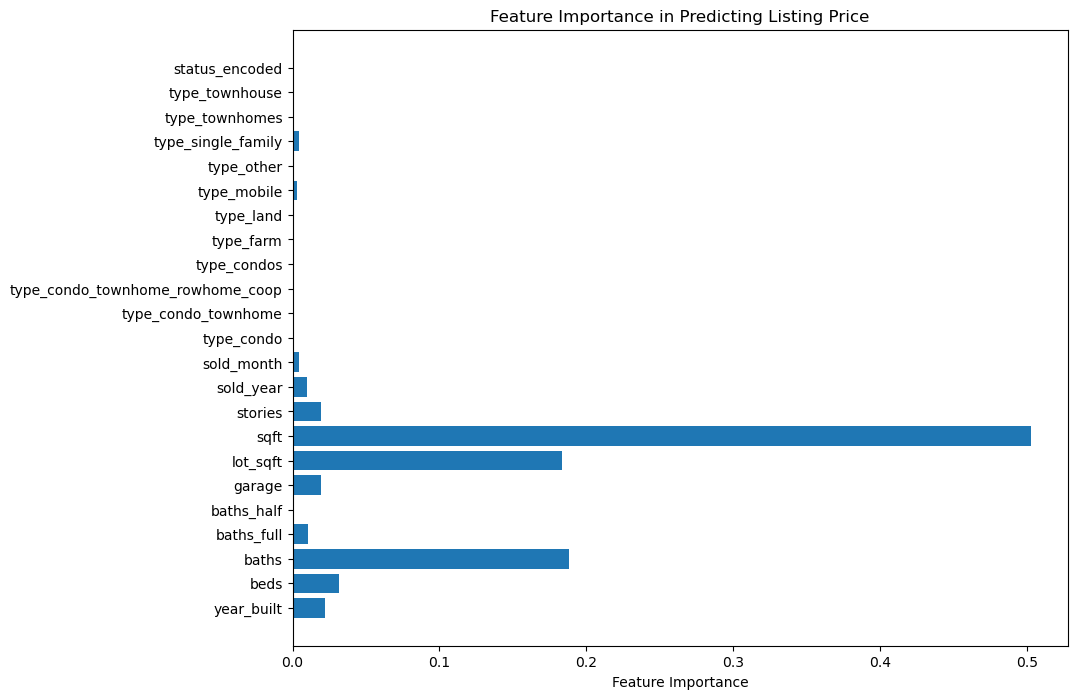

In [20]:
# Extract feature importance for the gradient boosting
feature_importances = best_model.feature_importances_
features = X_train.columns

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(features, feature_importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Predicting Listing Price")
plt.show()


This chart shows which features matter most, helping us understand what affects price most (e.g., square footage or bathrooms).

Feature Importance Interpretation

- Square Footage is the most influential factor, contributing over 50% to the model’s predictive power, indicating a strong correlation with listing price.
- Bathrooms and Lot Size together account for about 37% of feature importance, suggesting that larger lot sizes and additional bathrooms significantly impact property value.
- Bedrooms and Year Built have modest influence, reflecting that while additional bedrooms and newer construction add value, they are secondary compared to square footage and lot characteristics.
- Garage Presence and Property Stories provide minor but noticeable predictive value, indicating some buyer preference for these features.
- Property Type and Sale Date contribute minimally, showing limited impact on listing price within this dataset and market context.

In [21]:
# Prediction using the best model
y_pred = best_gb.predict(X_test_prepared)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Absolute Error: 229632.6085441442
Mean Squared Error: 250634549622.3414
R-squared: 0.6584553178319335


## Improving Top 3 ML Models for Better Predicition Accuracy:

In this section, we will focus on improving the top 3 models: Random Forest, Gradient Boosting, and Ridge Regression. These models were chosen because they showed the highest baseline scores during our initial model evaluation. Our goal is to increase the accuracy of these models to at least 80% by using additional preprocessing techniques, dimensionality reduction (PCA), and feature scaling (RobustScaler).

We’ll also create visualizations to better understand our models' performance, including ROC-AUC curves and a correlation matrix for feature selection insights.

### Data Preprocessing with RobustScaler

RobustScaler is helpful when dealing with data that may have outliers, as it scales the data using the median and the interquartile range. This can make models more robust to extreme values.


In [5]:
# Scale the data using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Dimensionality Reduction with PCA
To reduce noise and potentially improve model performance, we’ll apply Principal Component Analysis (PCA). PCA helps in selecting the most important components (features) for our models, which might improve their efficiency and accuracy.

In [6]:
# Apply PCA and keep enough components to explain 95% of the variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Print the number of components
print(f"Number of components after PCA: {pca.n_components_}")

Number of components after PCA: 1


### Improving and Evaluating Models
We’ll now train our three models using the scaled and PCA-transformed data, then evaluate each model's performance using Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R2) scores.

### Gradient Boosting

In [7]:
# Train Gradient Boosting on PCA-transformed data
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_pca, y_train)
y_pred_gb = gb_model.predict(X_test_pca)

In [8]:
# Evaluation metrics
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

In [9]:
print("Gradient Boosting Model Performance:")
print(f"Mean Absolute Error: {mae_gb}")
print(f"Mean Squared Error: {mse_gb}")
print(f"R-squared: {r2_gb}")

Gradient Boosting Model Performance:
Mean Absolute Error: 412112.0023959897
Mean Squared Error: 682662339290.3176
R-squared: 0.06972246223695977


### Random Forest

In [27]:
# Train Random Forest on PCA-transformed data
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_pca, y_train)
y_pred_rf = rf_model.predict(X_test_pca)

In [28]:
# Evaluation metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

In [29]:
print("Random Forest Model Performance:")
print(f"Mean Absolute Error: {mae_rf}")
print(f"Mean Squared Error: {mse_rf}")
print(f"R-squared: {r2_rf}")

Random Forest Model Performance:
Mean Absolute Error: 435451.6607232145
Mean Squared Error: 848284112909.354
R-squared: -0.15597362043025975


### Ridge Regression

In [30]:
# Train Ridge Regression on PCA-transformed data
ridge_model = Ridge(random_state=42)
ridge_model.fit(X_train_pca, y_train)
y_pred_ridge = ridge_model.predict(X_test_pca)

In [31]:
# Evaluation metrics
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

In [32]:
print("Ridge Regression Model Performance:")
print(f"Mean Absolute Error: {mae_ridge}")
print(f"Mean Squared Error: {mse_ridge}")
print(f"R-squared: {r2_ridge}")

Ridge Regression Model Performance:
Mean Absolute Error: 413869.88875899743
Mean Squared Error: 635821716213.0349
R-squared: 0.1335531102684897


The updated models show mixed performance, with R-squared values far below our goal of 80%. The Gradient Boosting model has the best (though still low) R-squared value at approximately 0.07, compared to the baseline of around 0.66 initially. Given the minimal improvement or negative changes, it would indeed be worth exploring RandomizedSearchCV for hyperparameter tuning alongside MinMaxScaler to normalize the features, which could further refine model performance.

### Attempt 3 Using MinMaxScaler and RandomizedSearchCV

### Apply MinMaxScaler
The MinMaxScaler scales each feature to a range between 0 and 1, which can help improve model training by ensuring features have similar scales.

In [10]:
# Initialize and apply MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### RandomizedSearchCV for Hyperparameter Tuning
Using RandomizedSearchCV will allow us to test a range of hyperparameters more efficiently than a Grid Search, which is beneficial given the current models' poor R-squared scores.

### Gradient Boosting Model Hyperparameter Tuning

In [11]:
# Define parameter grid for RandomizedSearchCV
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [12]:
# Initialize Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Set up RandomizedSearchCV with 10 iterations for efficient tuning
random_search_gb = RandomizedSearchCV(estimator=gb_model, param_distributions=param_grid_gb,
                                      n_iter=10, scoring='r2', cv=5, random_state=42, n_jobs=-1)
# Fit model
random_search_gb.fit(X_train_scaled, y_train)

# Best parameters and best score
print("Best parameters for Gradient Boosting:", random_search_gb.best_params_)
print("Best R-squared score for Gradient Boosting:", random_search_gb.best_score_)

Best parameters for Gradient Boosting: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.1}
Best R-squared score for Gradient Boosting: 0.5869963423907759


### Random Forest Model Hyperparameter Tuning

In [13]:
# Define parameter grid for RandomizedSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [14]:

# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf,
                                      n_iter=10, scoring='r2', cv=5, random_state=42, n_jobs=-1)
# Fit model
random_search_rf.fit(X_train_scaled, y_train)

# Best parameters and best score
print("Best parameters for Random Forest:", random_search_rf.best_params_)
print("Best R-squared score for Random Forest:", random_search_rf.best_score_)


Best parameters for Random Forest: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}
Best R-squared score for Random Forest: 0.5933659401616825


### Ridge Regression Model Hyperparameter Tuning

In [38]:
# Define parameter grid for RandomizedSearchCV
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']
}

In [19]:

# Initialize Ridge Regression model
ridge_model = Ridge(random_state=42)

# Set up RandomizedSearchCV
random_search_ridge = RandomizedSearchCV(estimator=ridge_model, param_distributions=param_grid_ridge,
                                         n_iter=10, scoring='r2', cv=5, random_state=42, n_jobs=-1)
# Fit model
random_search_ridge.fit(X_train_scaled, y_train)

# Best parameters and best score
print("Best parameters for Ridge Regression:", random_search_ridge.best_params_)
print("Best R-squared score for Ridge Regression:", random_search_ridge.best_score_)


NameError: name 'param_grid_ridge' is not defined

## Summary of Findings 